# Rational
<center>Development for a fitting function (greedy+linear based on mvpolyfit and gmvpfit) that handles rational fucntions</center>

In [1]:
# Low-level import 
from numpy import *
from numpy.linalg import pinv,lstsq
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import *
#
import positive
from positive import *

## Formalism: An algorithm to model rational functions in the pseudo-linear sense

1. Given $\psi$, and $\vec{x}$, such that 

$$  
\begin{align}
    \psi &= A(\vec{x}) / B(\vec{x}) \text{, where}
    \\
    A(\vec{x}) &= \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x})  
    \\
    B(\vec{x}) &= \sum_{k=0}^N ~ b_k \nu^{k}(\vec{x}) 
    \\ \nonumber
               &= 1 + \sum_{k=1}^{N} ~ b_k \nu^{k}(\vec{x})
\end{align}
$$

2. We will consider the following to be known and unknown:

 * **Known**: $\psi$, $\vec{x}$, $b_0=1$
 * **Unknown**: $a_k$, $b_k$ (and generally $\mu^j$, and $\nu^k$)
 
3. We seek to write this as a normal linear equation.These manipulations follow:

    $$
    \begin{align}
        &\rightarrow \psi B(\vec{x}) = A(\vec{x})
        \\ \nonumber
        &\rightarrow \psi + \sum_{k=1}^{N} ~ \psi b_k \nu^{k}(\vec{x}) = \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x}) 
        \\ \nonumber
        &\rightarrow \psi = \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x}) - \sum_{k=1}^{N} ~ \psi b_k \nu^{k}(\vec{x})
    \end{align}
    $$

4. We will consider $\psi$ and $\vec{x}$ to be descritized: $\psi_i$ and $\vec{x}_i$, with $0 \le i \le Q$. This gives

    $$
    \begin{align}
        \psi_i = \sum_{j=0}^M ~ a_j \mu^{j}(\vec{x}_i) - \sum_{k=1}^{N} ~ \psi_i b_k \nu^{k}(\vec{x}_i)
    \end{align}
    $$

5. Then, we note that the last line, upon a concatenation of the indeces, may be considered as a matrix operating on a vector. For simplicity we will write this matriv and vector notation.

    $$
    \begin{align}
        \vec{\psi} = \hat{\alpha} \vec{c}
    \end{align}
    $$

    with

    $$
    \begin{align}
        \vec{c} = (c_0,c_1,...c_k,c_k+1,...c_{M+N})
        \\ \nonumber
        c_k = \left\{\begin{array}{ll}
            a_k, & \text{for } 0\leq k \leq M\\
            b_{k-M}, & \text{for } M < k \leq M+N
            \end{array}\right\}
    \end{align}
    $$

    and

    $$
    \begin{align}
        \hat{\alpha} \text{ is of shape } Q \times (M+N+1) \text{, and has elements } \alpha^{k}(\vec{x}_j)
        \\ \nonumber
        \alpha^{k}(\vec{x}_j) = \left\{\begin{array}{ll}
            \mu^k(\vec{x}_j), & \text{for } 0\leq k \leq M\\
            -\psi_j \nu^k(\vec{x}_j), & \text{for } M < k \leq M+N
            \end{array}\right\}
    \end{align}
    $$
    
5. With this, $\vec{c}$ (the vector of fit coefficients) is determined via

    $$
        \vec{c} = \hat{\alpha}^{-1} \vec{\psi}
    $$

## Package Development (positive/learning.py)

(mvrfit)>> Centering ON. The input numerator symbols are ['K'], but ['00', '11', 'K'] will be used to accomodate centering.
(mvrfit)>> Max |residuals| = 0.035687
(mvrfit)>> exiting because z_is_small
[-1.14691939 -1.14419109  4.57994441]
[-0.99790168 -0.9945798 ]
1.69093053163e-06


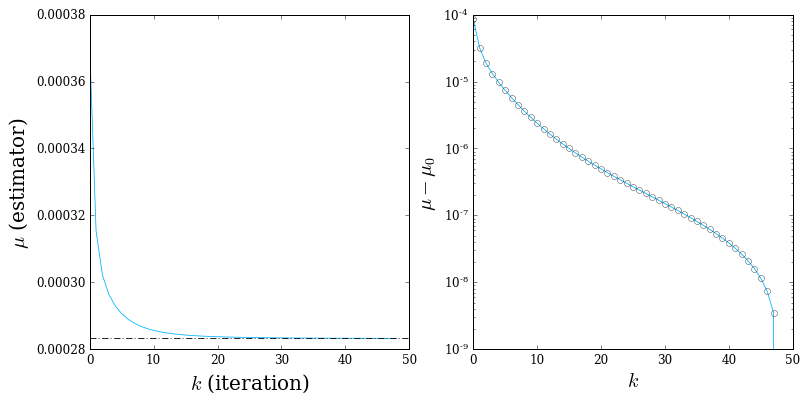

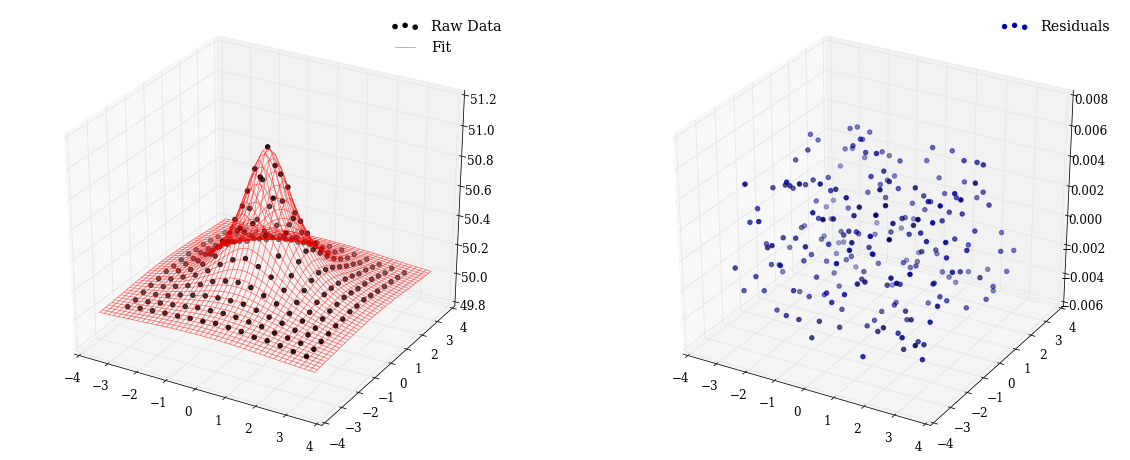

In [136]:
################################################################################
h = 3
Q = 15
x = h*linspace(-1,1,Q) 
y = h*linspace(-1,1,Q) 
X,Y = meshgrid(x,y)
# X += np.random.random( X.shape )-0.5
# Y += np.random.random( X.shape )-0.5
zfun = lambda xx,yy: 50 + 1.0 / ( 1.0 + xx**2 + yy**2 )
np.random.seed(42)
ns = 0.1*(np.random.random( X.shape )-0.5)
Z = zfun(X,Y) + ns
basis_symbols = ( ['K'], ['00','11'] ) # ( [Numerator], [Denominator without constant term] )
domain,scalar_range = ndflatten( [X,Y], Z )
################################################################################

# Solver for rational functions in the same form as those for polynomials
def mvrfit( domain, scalar_range, numerator_symbols, denominator_symbols, centering=True, verbose=True, method=0 ):
    '''
    
    Y = A / ( 1 - B )
    Y - YB = A
    Y = A + YB
    Y = A + B ( A + YB )
      = A + BA + Y B^2
      = A + AB + (A+YB) B^2
      = A + AB + A B^2 + Y B^3
      = A ( 1 + B + B^2 + B^3 + B^4 + ... + B^n ) + Y B^(n+1)

    Let R(n) = Y B^(n+1)
    Let H(n) = Y - Y B^(n+1)
    Let H = lim (n-->Inf) H(n) {Assumed to converge!}

    Consider H = V * c, where V is H's associated vandermonde matix and c is the related
    vector of coefficients.

    Y = AH c
    c = (AH)^{-1} Y

    This WOULD BE NICE; however, V is generally a very large matrix whose columns span
    nonlinear combinations of B's feature coefficients. This is a problem for building a
    fast and practical algoithm.

    But the idea of using recurssive inversion is a nice one. Let's hold on to it.

    Let us consider the following formulation of the above problem.

    Consider not

    Y = A + YB

    but

    Y(0) = A + Y(n)B
         = V(n)*x(n+1)  -->  x(n+1) = V(n)^-1 * Y(0) = a(n+1) U b(n+1)  -->  Y(n+1) = A(n+1) / ( 1 - B(n+1) )

    This, in principle, allows recurssive inversion with small matricies. Alternative formulations are possible:

    Y(0) = A + 0.5*(Y(n)+Y(n-1)) B

    But we don't do that here.
    
    # NOTES
    
    * Convergence is usually exponential, but there can sometimes be a kink in the exponential damping rate which causes slow convergence for low noise cases.
    
    '''
    
    #
    from numpy import mean,std

    # Shorthand
    mu = mean(scalar_range) if centering else 0
    sigma = std(scalar_range) if centering else 1.0
    centered_scalar_range = (scalar_range - mu) / sigma 
    denominator_symbols = sorted( list(denominator_symbols) )
    __numerator_symbols__ = numerator_symbols
    numerator_symbols = sorted(list( set( list(numerator_symbols) + denominator_symbols ) ) if centering else list(numerator_symbols))
    
    #
    if verbose:
        if centering:
            alert('Centering ON. The input numerator symbols are %s, but %s will be used to accomodate centering.'%( yellow(str(__numerator_symbols__)), yellow(str(numerator_symbols)) ) )
        else:
            warning('Centering is OFF. This will result in inaccurate results IF the data has a non-zero constant offset.')
    
    #
    numerator_coeffs, denominator_coeffs, fitfun = mvrslv0( domain, centered_scalar_range, numerator_symbols, denominator_symbols, mu=mu, sigma=sigma )
    residuals = scalar_range - fitfun( domain )
    alert('Max |residuals| = %f'%(max(abs(residuals))))
    #
    done = False; tol = 1e-5
    k = 0; kmax = 100; last_est = 1.0
    ##last_right_centered_scalar_range = centered_scalar_range
    est_list = []
    while not done:
        # Redefine the range values to be used on the right-hand-side
        ##right_centered_scalar_range = 0.5*(fitfun( domain, __centered__ = True ) + last_right_centered_scalar_range)
        right_centered_scalar_range = fitfun( domain, __centered__ = True )
        # Invert the linear form using these new values 
        numerator_coeffs, denominator_coeffs, fitfun = mvrslv0( domain, centered_scalar_range, numerator_symbols, denominator_symbols, mu=mu, sigma=sigma, right_centered_scalar_range=right_centered_scalar_range )
        ##last_right_centered_scalar_range = right_centered_scalar_range
        # Calculate estimators
        residuals = scalar_range - fitfun( domain )
        # est = max(abs(residuals))/max(abs(scalar_range)) # max(abs(residuals))
        est = abs(var(residuals)/var(scalar_range)) # max(abs(residuals))
        est_list.append(est)
        # Determine whether the process has converged
        # NOTE that there is a smarter stopping condition based on the expectation of exponential convergence
        z = abs(last_est-est) / (est_list[0] if k>0 else 1.0)
        #
        k_is_large = k>kmax
        if k_is_large: alert('exiting because k_is_large')
        z_is_small = z<tol
        if z_is_small: alert('exiting because z_is_small')
        #est_grew = est > last_est
        #if est_grew: alert('exiting becuase the estimator grew')
        done = k_is_large or z_is_small # or est_grew
        #
        if True:#est < last_est :
            fit_info = { 'numerator_coeffs':numerator_coeffs, 'denominator_coeffs':denominator_coeffs, 'residuals':residuals, 'fitfun':fitfun }
            last_est = est
        #else:
        #    est_list = est_list[:-1]
        #    done = True
        #
        k += 1
            
    #
    est_list = array(est_list)
    est0 = min(est_list)
    est1 = est_list[-1]
    figure( figsize=3*array([4.2,2]) )
    clr = rgb(1)
    #
    subplot(1,2,1)
    plot(est_list,linestyle='-',color=clr[0] )
    axhline( est1, color='k', linestyle=':' )
    axhline( est0, color='k', linestyle='--' )
    xlabel('$k$ (iteration)')
    ylabel(r'$\mu$ (estimator)')
    #
    subplot(1,2,2)
    x = abs(est_list-est0)
    plot(x,linestyle='-',color=clr[0] )
    plot(x,'ok',alpha=0.7,mec='k',mfc='none' )
    xlabel('$k$')
    ylabel(r'$\mu-\mu_0$ ')
    yscale('log')
    
    
    
    #
    return fit_info
    


################################################################################
fit_info = mvrfit(domain, scalar_range, basis_symbols[0], basis_symbols[1], method=0 )
print fit_info['numerator_coeffs']
print fit_info['denominator_coeffs']
print mean(fit_info['residuals'])
################################################################################


#
fig = figure( figsize=2*array([10,4]) )
ax = fig.add_subplot(121,projection='3d')

# Plot the raw data points
ax.scatter( domain[:,0], domain[:,1], scalar_range, marker='o', color='k',zorder=1, facecolors='k',label='Raw Data')

# Setup grid points for model
padf = 0.1
dx = ( max(domain[:,0])-min(domain[:,0]) ) * padf
dy = ( max(domain[:,1])-min(domain[:,1]) ) * padf
fitx = linspace( min(domain[:,0])-dx, max(domain[:,0])+dx, 45 )
fity = linspace( min(domain[:,1])-dy, max(domain[:,1])+dy, 45 )
xx,yy = meshgrid( fitx, fity )
fitdomain,_ = ndflatten( [xx,yy], yy )
# Plot model on grid
zz = fit_info['fitfun']( fitdomain ).reshape( xx.shape )
ax.plot_wireframe(xx, yy, zz, color='r', rstride=1, cstride=1,zorder=1,alpha=0.5,label='Fit')

legend(frameon=False)

ax = fig.add_subplot(122,projection='3d')
ax.scatter( domain[:,0], domain[:,1], fit_info['residuals'].reshape( domain[:,0].shape ), marker='o', color='b',zorder=1, facecolors='k',label='Residuals')
legend(frameon=False)

## 